<a href="https://colab.research.google.com/github/melbanna3/Movies-Reviews-Classification-Using-BERT/blob/main/Classification-Using-BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing and Reading the Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/AI/IMDB.csv')

In [ ]:
Data  = df.to_numpy()
labels = Data[:,1]
Data = Data[:,0]
labels=np.reshape(labels,(np.shape(labels)[0],1))
Data=np.reshape(Data,(np.shape(Data)[0],1))
Data = Data[:,0]
Ylab = labels[:,0]

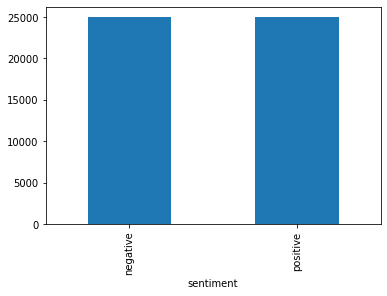

In [ ]:
df.groupby(['sentiment']).size().plot.bar()

# **Text Pre-processing**

In [ ]:
import nltk
nltk.download('punkt') #punctuation
nltk.download('stopwords') #stopwords
nltk.download('wordnet') #lemmatization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import string 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
tokenizer = nltk.RegexpTokenizer(r"\w+")
preprocessed_data = []
for d in Data:
  new_words = tokenizer.tokenize(d.lower())
  lemmatizer = WordNetLemmatizer()
  filtered_sentence = []

  for w in new_words:
      if w not in stop_words:
          filtered_sentence.append(w)
  for i in range(0,len(filtered_sentence)):
    filtered_sentence[i] = lemmatizer.lemmatize(filtered_sentence[i])

  new_data = " ".join(filtered_sentence)
  preprocessed_data.append(new_data)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


# **Splitting Data**

In [ ]:
from sklearn.model_selection import train_test_split

def split_data(Data,labels):
  train,test,trainLabels,testLabels=train_test_split(Data[:], labels[:], test_size=0.2, random_state=5, stratify=labels[:])
  train,val,trainLabels,valLabels=train_test_split(train[:], trainLabels[:], test_size=0.125, random_state=5, stratify=trainLabels[:])
  return train,val,test,trainLabels,valLabels,testLabels

In [ ]:
train,val,test,trainLabels,valLabels,testLabels = split_data(preprocessed_data,Ylab)
trainW,valW,testW,trainLabelsW,valLabelsW,testLabelsW = split_data(Data,Ylab)

In [ ]:
pos=0
for lab in trainLabels:
  if lab == 'positive': pos +=1
print('Number of positives in train: ',pos)
print('Size of train: ',np.shape(train)[0])

pos=0
for lab in testLabels:
  if lab == 'positive': pos +=1
print('Number of positives in test:',pos)
print('Size of test: ',np.shape(test)[0])

Number of positives in train:  17500
Size of train:  35000
Number of positives in test: 5000
Size of test:  10000


# **Bert Model**

In [ ]:
!pip install transformers
import torch
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 28.7 MB/s 
     |████████████████████████████████| 101 kB 14.4 MB/s 
     |████████████████████████████████| 6.6 MB 45.2 MB/s 
     |████████████████████████████████| 596 kB 73.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labelsCon = {'negative':0,'positive':1, }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, X,Y):

        # self.labels = [labels[label] for label in Y]
        self.labels = []
        for label in Y:
          self.labels.append(labelsCon[label])
        self.texts=[]
        for text in X :
          self.texts.append( tokenizer
                      (text, padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt"))
        # self.texts = [tokenizer
        #               (text, padding='max_length', max_length = 512, truncation=True,
        #                         return_tensors="pt") for text in X]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.2):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)

        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(64)

        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, clsToken = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False) 
        x = self.dropout(clsToken)
        
        x = self.fc1(x)
        # x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        # x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        # x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        # x = self.bn4(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.output(x)
        x = self.sigmoid(x)
        return x

In [ ]:
def train_Model(model,trainDataLoader,valDataLoader,trainLabels,valLabels,lr,epochs):

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  criterion = nn.BCEWithLogitsLoss()
  optimizer = Adam(model.parameters(), lr= lr)
  
  if use_cuda:
    model = model.cuda()
    criterion = criterion.cuda()
    print("Running on Cuda GPU")
  trainAccuracy_list = list(np.load('/content/drive/MyDrive/AI/trainAccuracy_list0.0001.npy'))
  trainLoss_list = list(np.load('/content/drive/MyDrive/AI/trainLoss_list0.0001.npy'))
  valAccuracy_list = list(np.load('/content/drive/MyDrive/AI/valAccuracy_list0.0001.npy'))
  valLoss_list = list(np.load('/content/drive/MyDrive/AI/valLoss_list0.0001.npy'))
  best = np.load('/content/drive/MyDrive/AI/best0.0001.npy')
  for epoch in range(3,epochs):
            trainAcc = 0
            trainLoss = 0

            for train_input, train_label in tqdm(trainDataLoader):

                train_label = train_label.to(device)
                train_label = train_label.to(torch.float32)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.unsqueeze(1))
                trainLoss += batch_loss.item()              
                output = torch.round(output)
                for j in range(0,len(output)):
                      if output[j] == train_label[j]:
                        trainAcc += 1

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
              
            valAcc = 0
            valLoss = 0
            with torch.no_grad():

                for val_input, val_label in valDataLoader:

                    val_label = val_label.to(device)
                    val_label = val_label.to(torch.float32)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)
                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.unsqueeze(1))
                    valLoss += batch_loss.item()
                    output = torch.round(output)

                    for j in range(0,len(output)):
                      if output[j] == val_label[j]:
                        valAcc += 1
            
            print(
                f'Epochs: {epoch + 1} | Train Loss: {trainLoss / len(trainDataLoader.dataset): .3f} \
                | Train Accuracy: {trainAcc / len(trainDataLoader.dataset): .3f} \
                | Val Loss: {valLoss / len(valDataLoader.dataset): .3f} \
                | Val Accuracy: {valAcc / len(valDataLoader.dataset): .3f}')
            
            trainAccuracy_list.append(trainAcc / len(trainDataLoader.dataset))
            trainLoss_list.append(trainLoss / len(trainDataLoader.dataset))
            valAccuracy_list.append(valAcc / len(valDataLoader.dataset))
            valLoss_list.append(valLoss / len(valDataLoader.dataset))
            
            if valAccuracy_list[epoch] >= valAccuracy_list[best] :
              best = epoch
              torch.save(model,'/content/drive/MyDrive/AI/model'+str(lr)+'.pt')
            if epoch-2 > best:
              break
            np.save('/content/drive/MyDrive/AI/best'+str(lr),best)
            np.save('/content/drive/MyDrive/AI/trainAccuracy_list'+str(lr),trainAccuracy_list)
            np.save('/content/drive/MyDrive/AI/trainLoss_list'+str(lr),trainLoss_list)
            np.save('/content/drive/MyDrive/AI/valAccuracy_list'+str(lr),valAccuracy_list)
            np.save('/content/drive/MyDrive/AI/valLoss_list'+str(lr),valLoss_list)

In [ ]:
def train_ModelW(model,trainDataLoader,valDataLoader,trainLabels,valLabels,lr,epochs):

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  criterion = nn.BCEWithLogitsLoss()
  optimizer = Adam(model.parameters(), lr= lr)
  
  if use_cuda:
    model = model.cuda()
    criterion = criterion.cuda()
    print("Running on Cuda GPU")
  trainAccuracy_list = []
  trainLoss_list = []
  valAccuracy_list = []
  valLoss_list = []
  best = 0
  for epoch in range(0,epochs):
            trainAcc = 0
            trainLoss = 0

            for train_input, train_label in tqdm(trainDataLoader):

                train_label = train_label.to(device)
                train_label = train_label.to(torch.float32)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.unsqueeze(1))
                trainLoss += batch_loss.item()              
                output = torch.round(output)
                for j in range(0,len(output)):
                      if output[j] == train_label[j]:
                        trainAcc += 1

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
              
            valAcc = 0
            valLoss = 0
            with torch.no_grad():

                for val_input, val_label in valDataLoader:

                    val_label = val_label.to(device)
                    val_label = val_label.to(torch.float32)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)
                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.unsqueeze(1))
                    valLoss += batch_loss.item()
                    output = torch.round(output)

                    for j in range(0,len(output)):
                      if output[j] == val_label[j]:
                        valAcc += 1
            
            print(
                f'Epochs: {epoch + 1} | Train Loss: {trainLoss / len(trainDataLoader.dataset): .3f} \
                | Train Accuracy: {trainAcc / len(trainDataLoader.dataset): .3f} \
                | Val Loss: {valLoss / len(valDataLoader.dataset): .3f} \
                | Val Accuracy: {valAcc / len(valDataLoader.dataset): .3f}')
            
            trainAccuracy_list.append(trainAcc / len(trainDataLoader.dataset))
            trainLoss_list.append(trainLoss / len(trainDataLoader.dataset))
            valAccuracy_list.append(valAcc / len(valDataLoader.dataset))
            valLoss_list.append(valLoss / len(valDataLoader.dataset))
            
            if valAccuracy_list[epoch] >= valAccuracy_list[best] :
              best = epoch
              torch.save(model,'/content/drive/MyDrive/AI/modelW'+str(lr)+'.pt')
            if epoch-2 > best:
              break
            np.save('/content/drive/MyDrive/AI/bestW'+str(lr),best)
            np.save('/content/drive/MyDrive/AI/trainAccuracy_listW'+str(lr),trainAccuracy_list)
            np.save('/content/drive/MyDrive/AI/trainLoss_listW'+str(lr),trainLoss_list)
            np.save('/content/drive/MyDrive/AI/valAccuracy_listW'+str(lr),valAccuracy_list)
            np.save('/content/drive/MyDrive/AI/valLoss_listW'+str(lr),valLoss_list)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate(model,test_dataloader,testLabels):
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  if use_cuda:

    model = model.cuda()

    tp, tn, fp, fn = 0,0,0,0
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            output = torch.round(output) 
            for i in range(0,len(output)) :
                if(output[i] == test_label[i]) :
                    if (output[i] == 1) : 
                        tp += 1
                    else:
                        tn += 1
                else:
                    if (output[i] == 1) : 
                        fp += 1
                    else:
                        fn += 1
    conf = np.array([[tp,fp],[fn,tn]])
    lab = [0,1]
    disp = ConfusionMatrixDisplay(confusion_matrix=conf,display_labels=lab)
    disp = disp.plot()
    plt.show()
    print("Confusion Matrix :-")
    print(f"{tp}   {fp}")
    print(f"{fn}   {tn}")
    precision, recall = (tp)/(tp+fp), (tp)/(tp+fn)
    print(f"Accuracy is: {(tp+tn)/(tp+tn+fp+fn):.3f}")
    print(f"Specificity is: {(tn)/(tn+fp):.3f} ")
    print(f"Precision is: {precision:.3f}")
    print(f"Recall is: {recall :.3f}")
    print(f"F1 score is: {2 * (precision * recall) / (precision + recall):.3f}")

In [ ]:
def plotting(lr):
  trainAccuracy1=np.load('/content/drive/MyDrive/AI/trainAccuracy_list'+str(lr)+'.npy')
  trainLoss1=np.load('/content/drive/MyDrive/AI/trainLoss_list'+str(lr)+'.npy')
  valAccuracy1=np.load('/content/drive/MyDrive/AI/valAccuracy_list'+str(lr)+'.npy')
  valLoss1=np.load('/content/drive/MyDrive/AI/valLoss_list'+str(lr)+'.npy')
  xx=[1,2,3,4,5]
  fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10))
  fig.suptitle('Model '+str(lr)+' plot')
  ax1.plot(xx, valLoss1,'g',xx,trainLoss1,'orange')
  ax2.plot(xx,valAccuracy1,'r',xx,trainAccuracy1,'black')

  l=[]
  l.append("validation loss")
  l.append("training loss")
  ax1.legend(l)

  ll=[]
  ll.append("validation accuracy")
  ll.append("training accuracy")
  ax2.legend(ll)

def plottingW(lr):
  trainAccuracy1=np.load('/content/drive/MyDrive/AI/trainAccuracy_listW'+str(lr)+'.npy')
  trainLoss1=np.load('/content/drive/MyDrive/AI/trainLoss_listW'+str(lr)+'.npy')
  valAccuracy1=np.load('/content/drive/MyDrive/AI/valAccuracy_listW'+str(lr)+'.npy')
  valLoss1=np.load('/content/drive/MyDrive/AI/valLoss_listW'+str(lr)+'.npy')
  xx=[1,2,3,4,5]
  fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10))
  fig.suptitle('Model '+str(lr)+' without pre-proccessing plot')
  ax1.plot(xx, valLoss1,'g',xx,trainLoss1,'orange')
  ax2.plot(xx,valAccuracy1,'r',xx,trainAccuracy1,'black')

  l=[]
  l.append("validation loss")
  l.append("training loss")
  ax1.legend(l)

  ll=[]
  ll.append("validation accuracy")
  ll.append("training accuracy")
  ax2.legend(ll)

# **Data Without Preproccessing**

In [ ]:
batchSize = 16
trainData, valData = Dataset( trainW, trainLabelsW), Dataset( valW, valLabelsW)

train_dataloader = torch.utils.data.DataLoader(trainData, batch_size=batchSize, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(valData, batch_size=batchSize)

In [ ]:
testData = Dataset(testW,testLabelsW)
test_dataloader = torch.utils.data.DataLoader(testData, batch_size=batchSize)

# **Data With Preproccessing**

In [ ]:
batchSize = 16
trainDataPre, valDataPre = Dataset( train, trainLabels), Dataset( val, valLabels)
train_dataloaderPre = torch.utils.data.DataLoader(trainDataPre, batch_size=batchSize, shuffle=True)
val_dataloaderPre = torch.utils.data.DataLoader(valDataPre, batch_size=batchSize)
testDataPre = Dataset(test,testLabels)
test_dataloaderPre = torch.utils.data.DataLoader(testDataPre, batch_size=batchSize)

# **Training Models with different Learning Rates**

In [ ]:
lrate = [1e-4,1e-5,1e-6]

In [ ]:
import gc
for _ in range(0,100):
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
lr = 1e-4
torch.cuda.empty_cache()
model = BertClassifier()
train_Model(model,train_dataloaderPre,val_dataloaderPre,trainLabels,valLabels,lr,epochs=5)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Running on Cuda GPU


100%|██████████| 2188/2188 [51:47<00:00,  1.42s/it]


Epochs: 1 | Train Loss:  0.043                 | Train Accuracy:  0.500                 | Val Loss:  0.043                 | Val Accuracy:  0.500


100%|██████████| 2188/2188 [51:49<00:00,  1.42s/it]


Epochs: 2 | Train Loss:  0.043                 | Train Accuracy:  0.500                 | Val Loss:  0.043                 | Val Accuracy:  0.500


100%|██████████| 2188/2188 [51:50<00:00,  1.42s/it]


Epochs: 3 | Train Loss:  0.043                 | Train Accuracy:  0.500                 | Val Loss:  0.043                 | Val Accuracy:  0.500


100%|██████████| 2188/2188 [51:49<00:00,  1.42s/it]


In [ ]:
lr = 1e-4
torch.cuda.empty_cache()
model = BertClassifier()
train_ModelW(model,train_dataloader,val_dataloader,trainLabelsW,valLabelsW,lr,epochs=5)

# **Tuning Models with pre-proccessing**

Best Epoch Number :  3


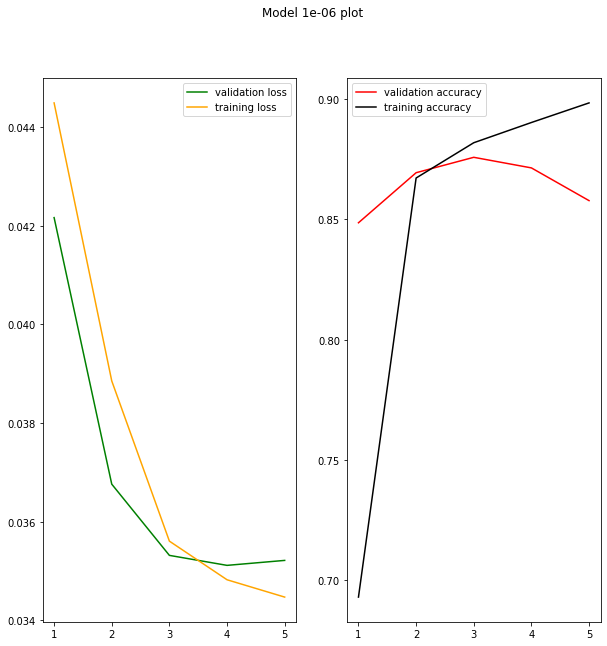

In [ ]:
best1=np.load('/content/drive/MyDrive/AI/best1e-06.npy')
print("Best Epoch Number : ",best1+1)
plotting(1e-06)

Best Epoch Number :  2


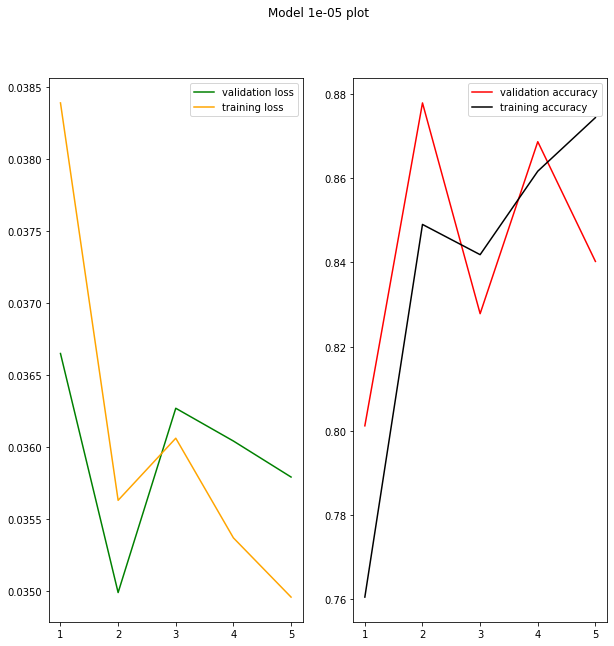

In [ ]:
best2=np.load('/content/drive/MyDrive/AI/best1e-05.npy')
print("Best Epoch Number : ",best2+1)
plotting(1e-05)

Best Epoch Number :  5


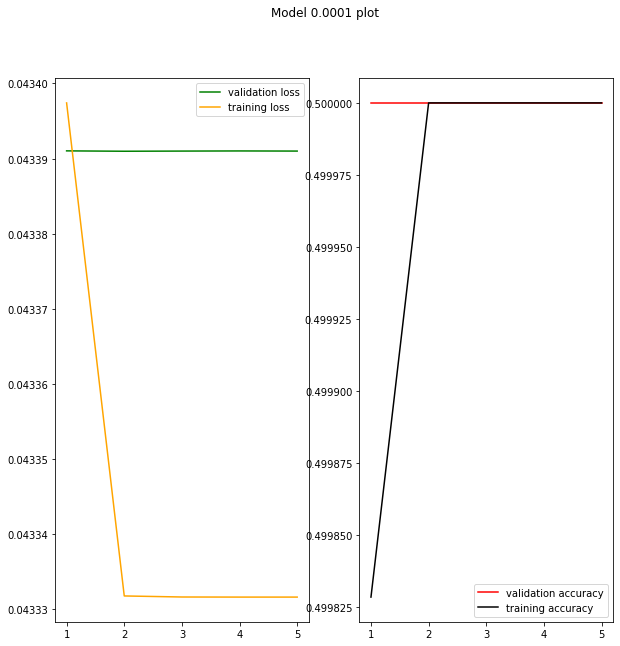

In [ ]:
best3=np.load('/content/drive/MyDrive/AI/best0.0001.npy')
print("Best Epoch Number : ",best3+1)
plotting(0.0001)

In [ ]:
def plotAcc():
  valAccuracy1=np.load('/content/drive/MyDrive/AI/valAccuracy_list1e-06.npy')
  valAccuracy2=np.load('/content/drive/MyDrive/AI/valAccuracy_list1e-05.npy')
  valAccuracy3=np.load('/content/drive/MyDrive/AI/valAccuracy_list0.0001.npy')
  xx=[1,2,3,4,5]
  plt.title('Validation Accuracies between different learning rates')
  plt.plot(xx, valAccuracy1,'g',xx,valAccuracy2,'orange',xx,valAccuracy3,'black')
  l=[]
  l.append("1e-06 learning rate")
  l.append("1e-05 learning rate")
  l.append("1e-04 learning rate")
  plt.legend(l)
  plt.show()

In [ ]:
plotAcc()

The Best Model is with learning rate 1e-05 with validation accuracy 0.878


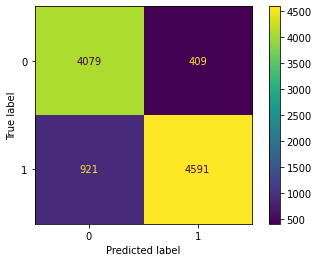

Confusion Matrix :-
4079   409
921   4591
Accuracy is: 0.867
Specificity is: 0.918 
Precision is: 0.909
Recall is: 0.816
F1 score is: 0.860


In [ ]:
print("The Best Model is with learning rate 1e-05 with validation accuracy 0.878")
Model=torch.load('/content/drive/MyDrive/AI/model1e-05.pt')
evaluate(Model,test_dataloaderPre,testLabels)

# **Tuning Models without pre-proccessing**

Best Epoch Number :  4


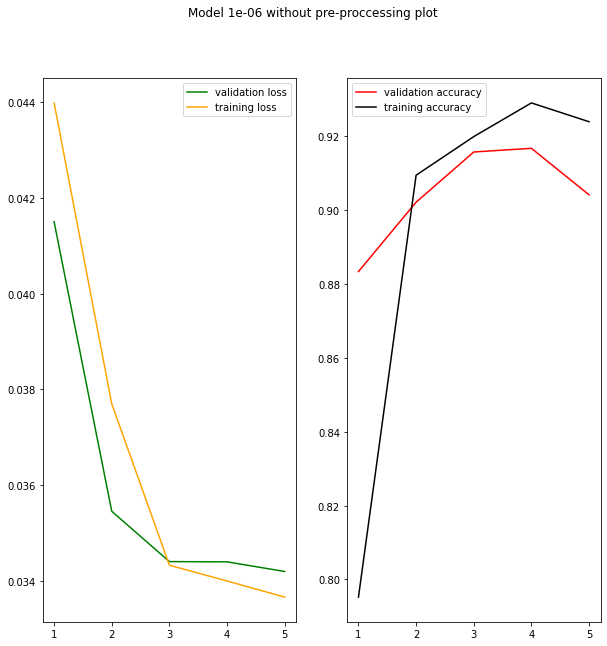

In [ ]:
best1=np.load('/content/drive/MyDrive/AI/bestW1e-06.npy')
print("Best Epoch Number : ",best1+1)
plottingW(1e-06)

Best Epoch Number :  5


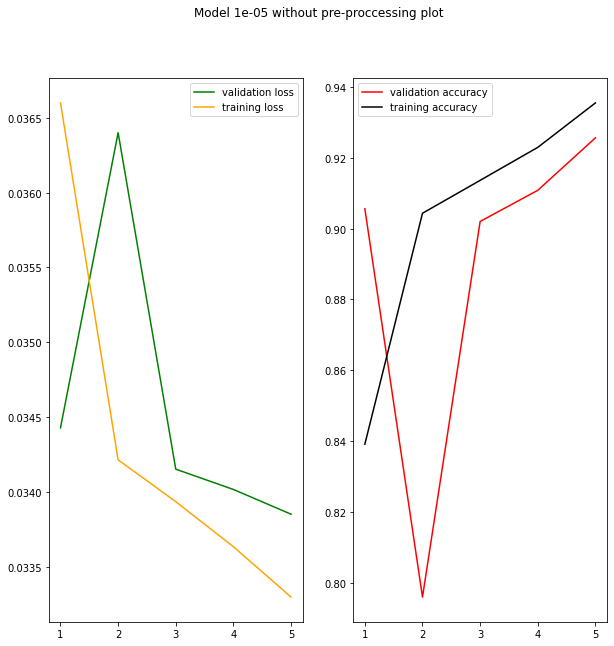

In [ ]:
best2=np.load('/content/drive/MyDrive/AI/bestW1e-05.npy')
print("Best Epoch Number : ",best2+1)
plottingW(1e-05)

In [ ]:
a = np.load("/content/drive/MyDrive/AI/best1e-04.npy")

In [ ]:
best3=np.load('/content/drive/MyDrive/AI/bestW0.0001.npy')
print("Best Epoch Number : ",best3+1)
plottingW(1e-04)

In [ ]:
def plotAccW():
  valAccuracy1=np.load('/content/drive/MyDrive/AI/valAccuracy_listW1e-06.npy')
  valAccuracy2=np.load('/content/drive/MyDrive/AI/valAccuracy_listW1e-05.npy')
  valAccuracy3=np.load('/content/drive/MyDrive/AI/valAccuracy_listW1e-04.npy')
  xx=[1,2,3,4,5]
  plt.title('Validation Accuracies between different learning rates')
  plt.plot(xx, valAccuracy1,'g',xx,valAccuracy2,'orange',xx,valAccuracy3,'black')
  l=[]
  l.append("1e-06 learning rate")
  l.append("1e-05 learning rate")
  l.append("1e-04 learning rate")
  plt.legend(l)
  plt.show()

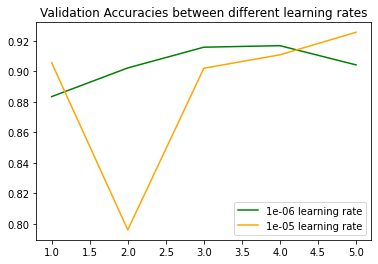

In [ ]:
plotAccW()

The Best Model without pre-proccessing is with learning rate 1e-05 with validation accuracy 0.926


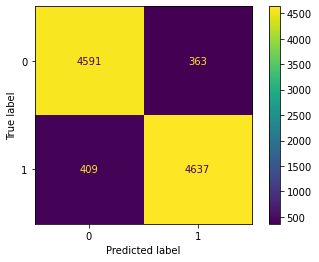

Confusion Matrix :-
4591   363
409   4637
Accuracy is: 0.923
Specificity is: 0.927 
Precision is: 0.927
Recall is: 0.918
F1 score is: 0.922


In [ ]:
print("The Best Model without pre-proccessing is with learning rate 1e-05 with validation accuracy 0.926")
Model=torch.load('/content/drive/MyDrive/AI/modelW1e-05.pt')
evaluate(Model,test_dataloader,testLabelsW)

In [ ]:
valAccuracy1=list(np.load('/content/drive/MyDrive/AI/trainAccuracy_listW0.0001.npy'))
valAccuracy1.append(0.5)
print(valAccuracy1)
np.save('/content/drive/MyDrive/AI/trainAccuracy_listW0.0001.npy',valAccuracy1)

[0.5, 0.5, 0.5, 0.5, 0.5]


In [ ]:
valAccuracy1=list(np.load('/content/drive/MyDrive/AI/valAccuracy_listW0.0001.npy'))
valAccuracy1.append(0.5)
print(valAccuracy1)
np.save('/content/drive/MyDrive/AI/valAccuracy_listW0.0001.npy',valAccuracy1)

In [ ]:
valAccuracy1=list(np.load('/content/drive/MyDrive/AI/trainLoss_list0.0001.npy'))
valAccuracy1.append(0.0433316019313235)
print(valAccuracy1)
best =4 
np.save('/content/drive/MyDrive/AI/best0.0001.npy',best)
np.save('/content/drive/MyDrive/AI/trainLoss_list0.0001.npy',valAccuracy1)

[0.0433974124789238, 0.043331753957271575, 0.04333161415883473, 0.0433316019313676, 0.0433316019313235]


In [ ]:
valAccuracy1=list(np.load('/content/drive/MyDrive/AI/valLoss_list0.0001.npy'))
valAccuracy1.append(0.043390997850024925)
print(valAccuracy1)
np.save('/content/drive/MyDrive/AI/valLoss_list0.0001.npy',valAccuracy1)

[0.04339102588891983, 0.04339097517728806, 0.043390997850894925, 0.043391015446186065, 0.043390997850024926]
